# Импорт и считывание данных

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


import category_encoders as ce

In [29]:
df = pd.read_csv('NY-House-Dataset.csv')

# Гайд по работе с проектом

0. Загружаем "Импорт", "Вспомогательные функции", при желании можно запустить "Вспомогательные визуализации"
1. Проект не нуждается в определенной последовательности запуска ячеек, все эксперименты находятся в разных разделах

# Вспомогательные Функции

## Базовые обработки данных

In [47]:
def quantile_destroyer(df, target=df['PRICE'], 
                           left_quantile=0.05, 
                           right_quantile=0.95):
        half_quantile = np.quantile(target, left_quantile)
        thalf_quantile = np.quantile(target, right_quantile)

        df = df[(target <= thalf_quantile) & (target >= half_quantile)]

        return df

def logical_killer(df,
                logical_columns = ['ADDRESS', 
                                   'MAIN_ADDRESS', 
                                   'FORMATTED_ADDRESS'],
                noninfo_columns = ['STATE',
                                   'LOCALITY',
                                   'LONG_NAME',
                                   'ADMINISTRATIVE_AREA_LEVEL_2',
                                   'SUBLOCALITY']):
        df = df.drop(columns=logical_columns)
        df = df.drop(columns=noninfo_columns)

        return df
    
def target_coding(df, target=df['PRICE']):
        object_columns = df.select_dtypes(include=['object']).columns
        target_encoder = ce.TargetEncoder(cols=object_columns)
        df_encoded = target_encoder.fit_transform(df[object_columns], target)

        for col in object_columns:
            df[col] = df_encoded[col]

        return df, target_encoder, object_columns

def rooms_builder(df):
        df['ROOMS'] = df['BATH'] + df['BEDS']
        df = df.drop(columns=['BATH', 'BEDS'])

        return df
    
def data_standard_scaler(df, scaler=StandardScaler()):
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        
        return df, scaler
    
def scaler_plus_highcorr_destroyer(df, scaler=StandardScaler()):
        df = df.drop(columns=['SUBLOCALITY', 'LONG_NAME', 'LATITUDE', 'LONGITUDE'])
        df = df.drop(columns=['FORMATTED_ADDRESS'])
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        return df, scaler

## Базовые графики

In [48]:
def price_histogram(df):
    plt.hist(df['PRICE'], 
             color = 'green', 
             edgecolor = 'black',
             bins = int(200/5))

    plt.title('Histogram of PRICE')
    plt.xlabel('Price')
    plt.ylabel('Counts')

def features_corr(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm',
                center=0)
        
    plt.title('Матрица Корреляций')
    plt.show()

def feature_histogram(df):
    num_columns = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2
    plt.figure(figsize=(12, rows * 4))

    for i, column in enumerate(num_columns):
        plt.subplot(rows, 2, i + 1)
        if column == 'PRICE':
            plt.hist(np.log1p(df[column]), 
                     color='green', 
                     edgecolor='black', 
                     bins=int(200/5))
                
            plt.title('Histogram of log PRICE')
            plt.xlabel('Log(Price)')
        else:
            plt.hist(df[column], 
                     color='blue', 
                     edgecolor='black', 
                     bins=int(200/5))
                
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            
        plt.ylabel('Counts')

    plt.tight_layout()
    plt.show()

def corr_dependence(df):
    corr_matrix = df.corr()

    data_corr = corr_matrix.abs()
    sol = (data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))
                    .stack()
                    .sort_values(ascending=False))

    features = []
    corr = []

    for index, value in sol.items():
            # print(index, value)
        if(index[0] == 'PRICE'):
                # print(1)
            print(index[1],':', value)
            features.append(index[1])
            corr.append(value)
            
    data_coef_corr = pd.DataFrame(corr, 
                                  index = features, 
                                  columns = ['PRICE'])
    y1 = corr
    fig, ax = plt.subplots(figsize = (10,6))
    x = features
    ax.plot(x, y1, color='green', label='correl')
    plt.xticks(rotation=90)

    ax.grid(True)
    plt.xlabel('признак')
    plt.ylabel('correl')
    plt.title('Зависимость признаков от предсказываемого значения')
    leg = ax.legend(loc='lower left', frameon=True)

## Класс обучения моделей

In [49]:
def LSM_models_train(X_train, 
                     y_train):
        
    linreg_model = LinearRegression()
    lasso_model = Lasso()
    ridge_model = Ridge()
    elastic_model = ElasticNet()

    models_dict = {'linreg': linreg_model,
                    'lasso': lasso_model,
                    'ridge': ridge_model,
                    'elastic': elastic_model}
        
    for model_name, model in models_dict.items():
        model.fit(X_train, y_train)

    return models_dict
    
def grad_models_train(X_train, 
                        y_train,
                        max_iter=1000000, 
                        tol=1e-3, 
                        penalty='elasticnet', 
                        eta0=3e-4, 
                        learning_rate='adaptive',
                        n_iter_no_change=5):
        
    sgd_regressor_adagrad = SGDRegressor(max_iter=max_iter, 
                                        tol=tol, 
                                        penalty=penalty, 
                                        eta0=eta0, 
                                        learning_rate=learning_rate)
        
    sgd_regressor = SGDRegressor(max_iter=max_iter, 
                                tol=tol, 
                                penalty=penalty, 
                                eta0=eta0)
        
    sgd_regressor_adam = SGDRegressor(max_iter=max_iter, 
                                    tol=tol, 
                                    penalty=penalty, 
                                    eta0=eta0, 
                                    learning_rate=learning_rate, 
                                    n_iter_no_change=n_iter_no_change)
        
    models_dict = {'sgd_regressor_adagrad': sgd_regressor_adagrad,
                    'sgd_regressor': sgd_regressor,
                    'sgd_regressor_adam': sgd_regressor_adam}
        
    for model_name, model in models_dict.items():
        model.fit(X_train, y_train)

    return models_dict

## Подсчеты метрик

In [50]:
def metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test):
    for model_name, model in model_dict.items():
            # model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)

        if np.any(np.isinf(y_pred_train)) or np.any(np.isinf(y_pred)) or np.any(np.isnan(y_pred_train)) or np.any(np.isnan(y_pred)):
            print(f"{model_name}: Predictions contain infinity or NaN values.")
            continue

        y_pred_train_exp = np.exp(y_pred_train) - 1
        y_pred_exp = np.exp(y_pred) - 1
        y_train_exp = np.exp(y_train) - 1
        y_test_exp = np.exp(y_test) - 1

        if np.any(np.isinf(y_pred_train_exp)) or np.any(np.isinf(y_pred_exp)) or np.any(np.isnan(y_pred_train_exp)) or np.any(np.isnan(y_pred_exp)):
            print(f"{model_name}: Transformed predictions contain infinity or NaN values.")
            continue

        print(f"""
                {model_name}
                mse_test: {mean_squared_error(y_pred_exp, y_test_exp)}
                mse_train: {mean_squared_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                {model_name}
                mae_test: {mean_absolute_error(y_pred_exp, y_test_exp)}
                mae_train: {mean_absolute_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                {model_name}
                mape_test: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)}
                mape_train: {mean_absolute_percentage_error(y_train_exp, y_pred_train_exp)}
                {18*'-'}
                {model_name}
                r2_score_test: {r2_score(y_pred_exp, y_test_exp)}
                r2_score_train: {r2_score(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                """)
            
def metrics_counter_without_exp(model_dict, X_train, y_train, X_test, y_test):
    for model_name, model in model_dict.items():
                # model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)

        if np.any(np.isinf(y_pred_train)) or np.any(np.isinf(y_pred)) or np.any(np.isnan(y_pred_train)) or np.any(np.isnan(y_pred)):
            print(f"{model_name}: Predictions contain infinity or NaN values.")
            continue

        y_pred_train_exp = y_pred_train
        y_pred_exp = y_pred
        y_train_exp = y_train
        y_test_exp = y_test

        if np.any(np.isinf(y_pred_train_exp)) or np.any(np.isinf(y_pred_exp)) or np.any(np.isnan(y_pred_train_exp)) or np.any(np.isnan(y_pred_exp)):
            print(f"{model_name}: Transformed predictions contain infinity or NaN values.")
            continue

        print(f"""
                {model_name}
                mse_test: {mean_squared_error(y_pred_exp, y_test_exp)}
                mse_train: {mean_squared_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                {model_name}
                mae_test: {mean_absolute_error(y_pred_exp, y_test_exp)}
                mae_train: {mean_absolute_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                {model_name}
                mape_test: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)}
                mape_train: {mean_absolute_percentage_error(y_train_exp, y_pred_train_exp)}
                {18*'-'}
                {model_name}
                r2_score_test: {r2_score(y_pred_exp, y_test_exp)}
                r2_score_train: {r2_score(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                """)

# Необходимые визуализации

In [36]:
df = pd.read_csv('NY-House-Dataset.csv')

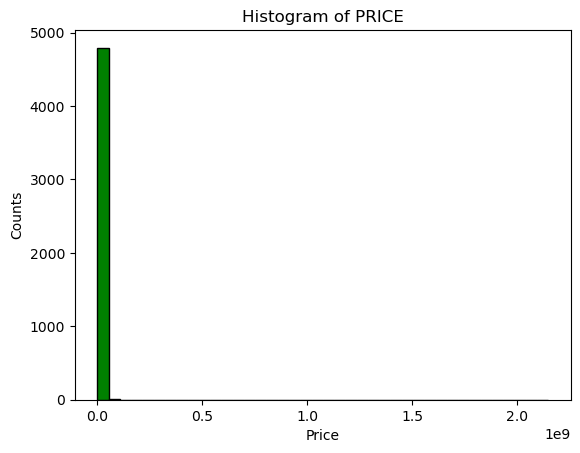

In [22]:
price_histogram(df)

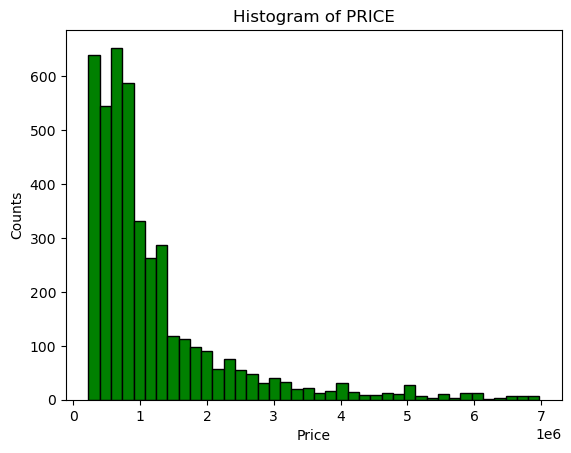

In [37]:
df = quantile_destroyer(df)

price_histogram(df)

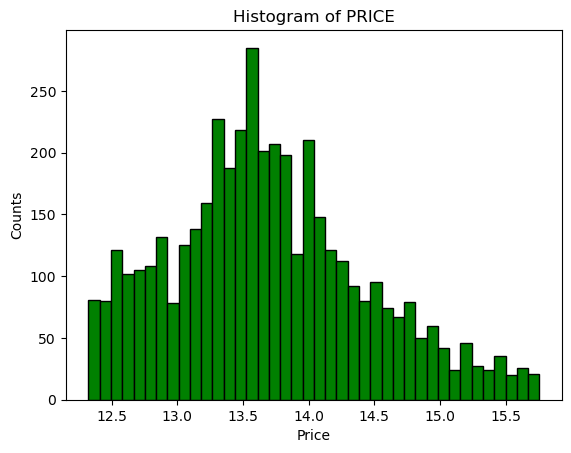

In [38]:
df['PRICE'] = np.log1p(df['PRICE'])

price_histogram(df)

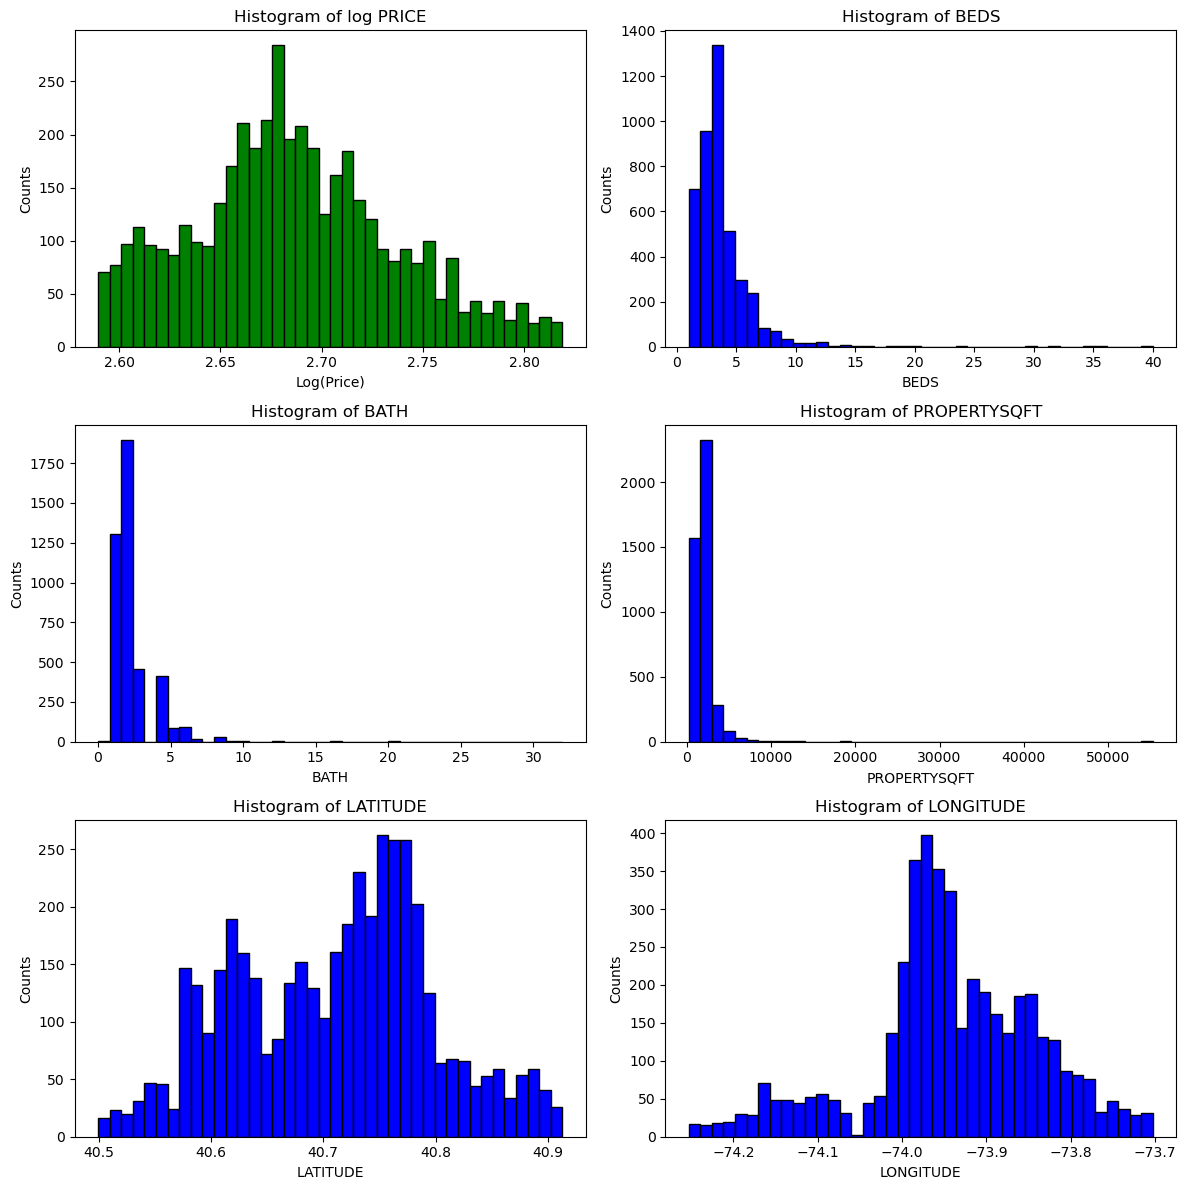

In [39]:
feature_histogram(df)

In [42]:
df, _, _ = target_coding(df, target=df['PRICE'])

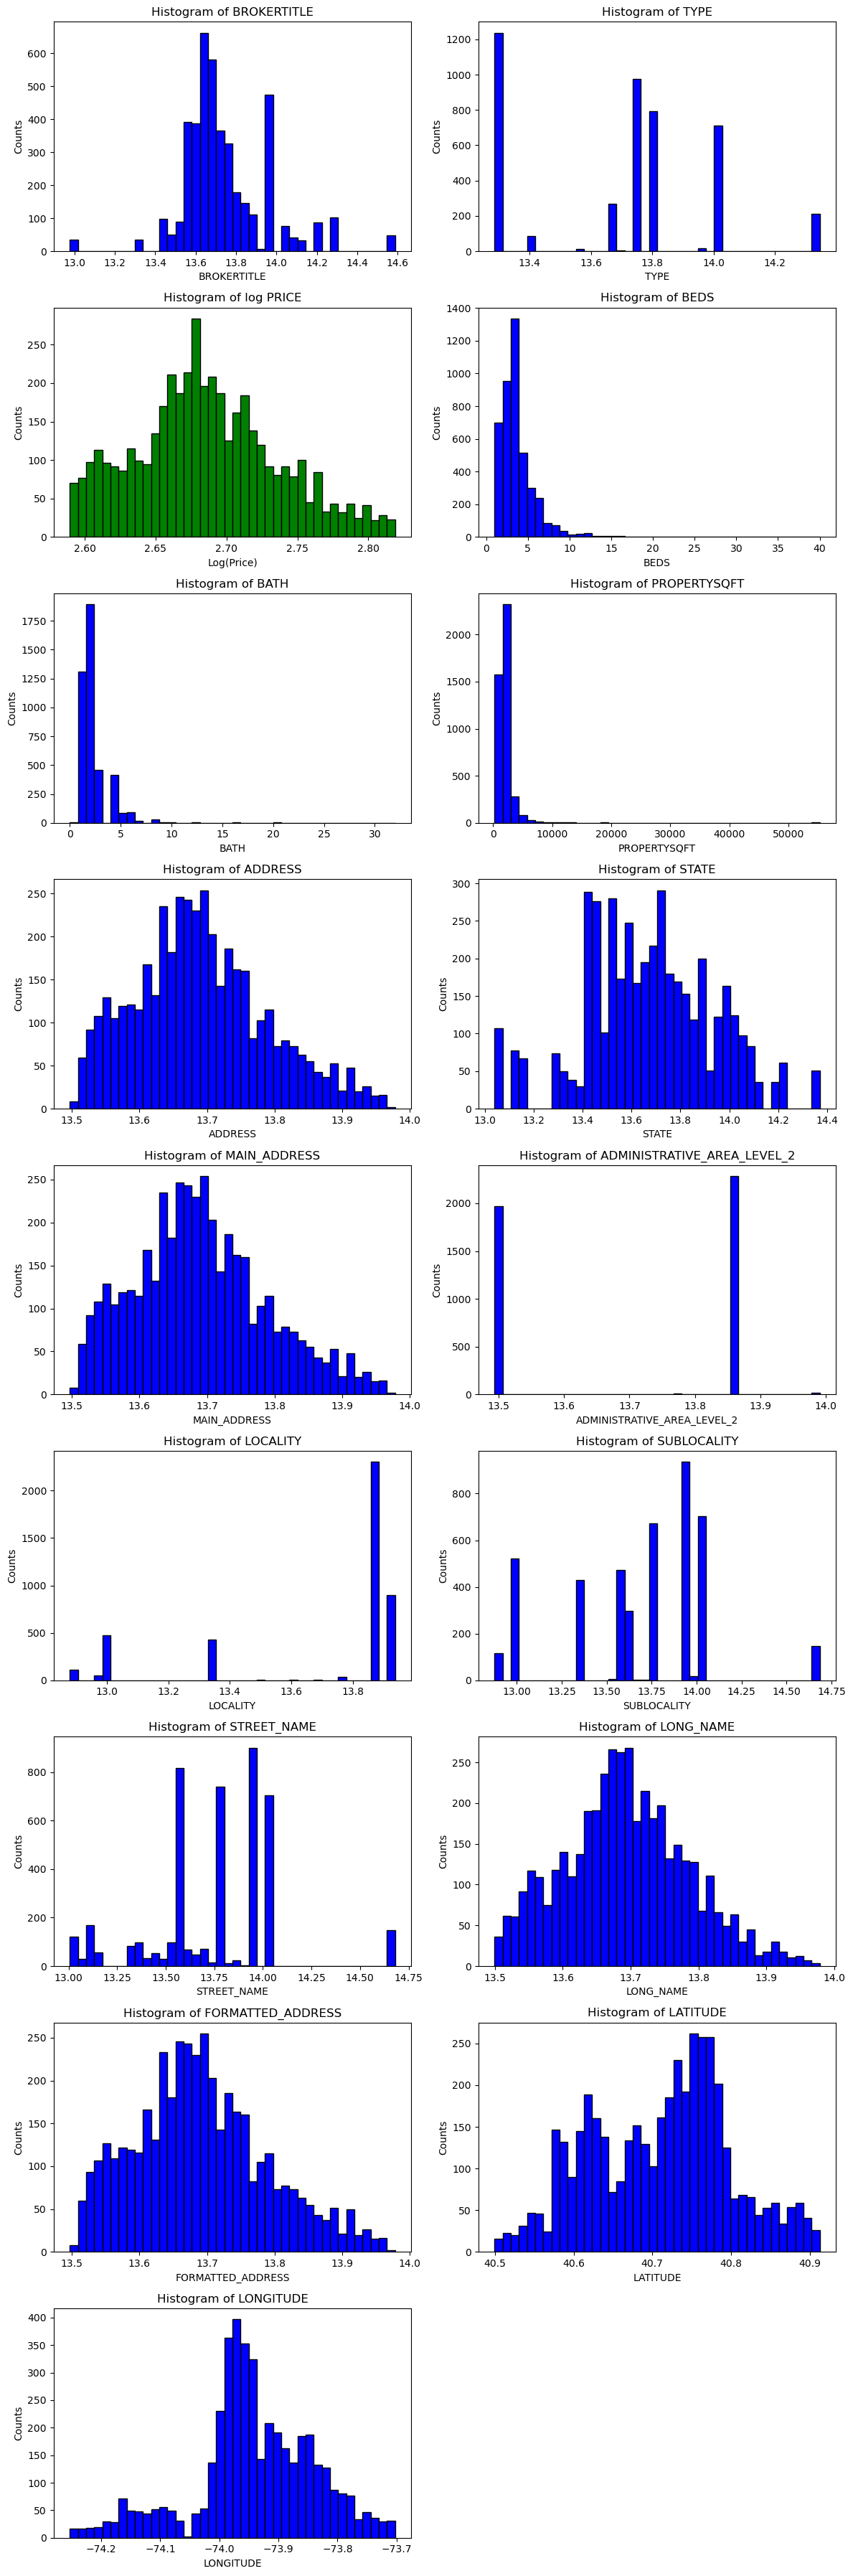

In [44]:
feature_histogram(df)

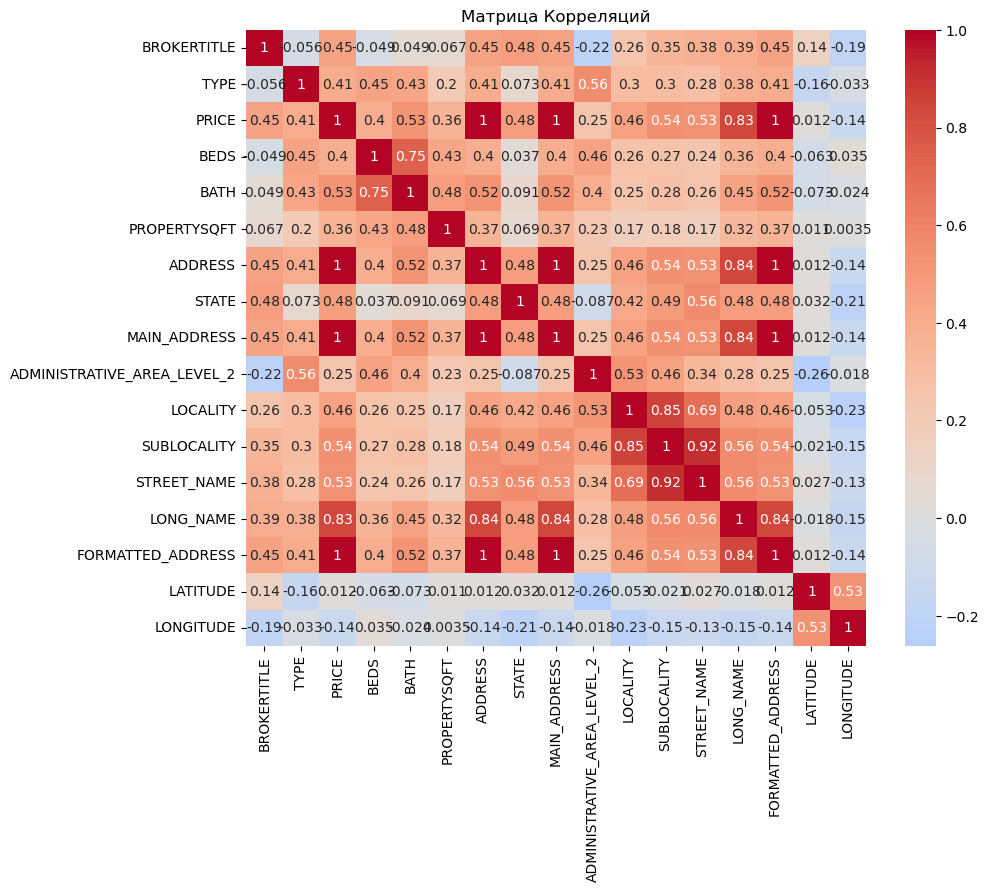

In [45]:
features_corr(df)

ADDRESS : 0.9996926449865055
MAIN_ADDRESS : 0.9996926449865055
FORMATTED_ADDRESS : 0.9991127674101695
LONG_NAME : 0.8343397123320435
SUBLOCALITY : 0.537557776231256
STREET_NAME : 0.5325459251787776
BATH : 0.5254105497263315
STATE : 0.4774369792126803
LOCALITY : 0.4596488317881446
BEDS : 0.3964119889375078
PROPERTYSQFT : 0.3644901740624479
ADMINISTRATIVE_AREA_LEVEL_2 : 0.2512015478400661
LONGITUDE : 0.1384149522368002
LATITUDE : 0.012232290750407262


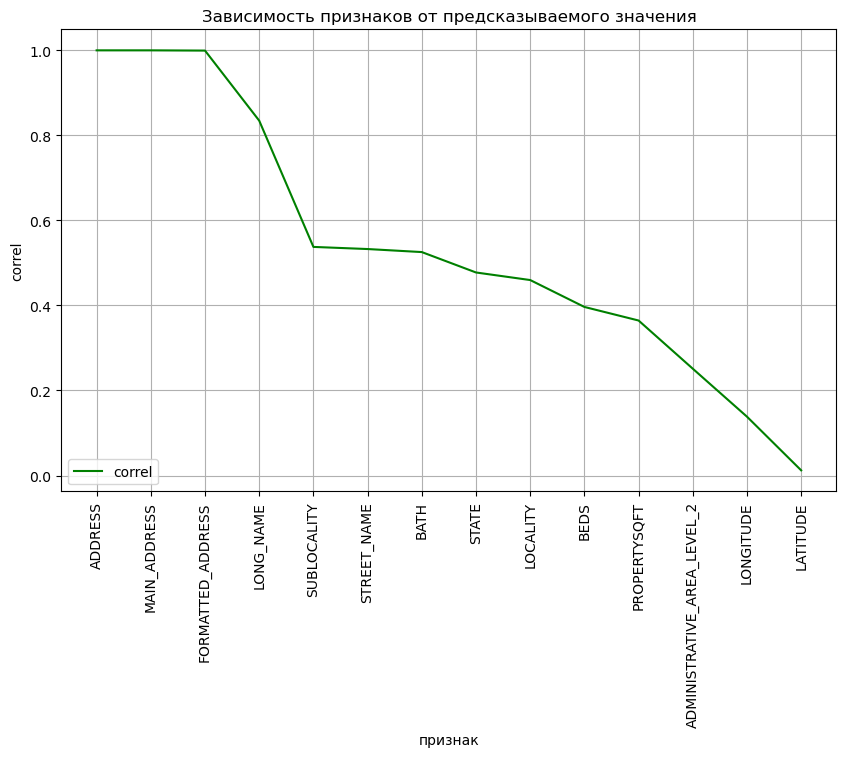

In [46]:
corr_dependence(df)

# Эксперименты

## Все фичи 

In [124]:
data = pd.read_csv('NY-House-Dataset.csv')
data = quantile_destroyer(df=data)
X = data.drop(columns=['PRICE'])
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, encoder, object_columns = target_coding(X_train, target=y_train)
X_test_enc = encoder.transform(X_test[object_columns])

for col in object_columns:
    X_test[col] = X_test_enc[col]

model_dict = LSM_models_train(X_train, y_train)


In [129]:
metrics_counter_without_exp(model_dict, X_train, y_train, X_test, y_test)

model_dict = grad_models_train(X_train, y_train)

metrics_counter_without_exp(model_dict, X_train, y_train, X_test, y_test)


                        linreg
                        mse_test: 1060177950748.6078
                        mse_train: 661566240.9902152
                        ------------------
                        linreg
                        mae_test: 686511.938322016
                        mae_train: 9250.679008585594
                        ------------------
                        linreg
                        mape_test: 0.8797645530275905
                        mape_train: 0.01138466145327267
                        ------------------
                        linreg
                        r2_score_test: -17.937166709270965
                        r2_score_train: 0.9994757065886849
                        ------------------
                    

                        lasso
                        mse_test: 1060184458468.1263
                        mse_train: 661567017.2717226
                        ------------------
                        lasso
                        mae_test: 

## Все фичи с log-трюком

In [130]:
data = pd.read_csv('NY-House-Dataset.csv')

data = quantile_destroyer(df=data)
X = data.drop(columns=['PRICE'])
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y),
                                                    test_size=0.2,
                                                    random_state=42)


X_train, encoder, object_columns = target_coding(X_train, target=y_train)
X_test_enc = encoder.transform(X_test[object_columns])

for col in object_columns:
    X_test[col] = X_test_enc[col]
    
model_dict = LSM_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)

model_dict = grad_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)


                    linreg
                    mse_test: 1165693416303.334
                    mse_train: 2855637731.1444707
                    ------------------
                    linreg
                    mae_test: 629949.5858776608
                    mae_train: 11327.656933338389
                    ------------------
                    linreg
                    mape_test: 0.60359688151463
                    mape_train: 0.006682077194674853
                    ------------------
                    linreg
                    r2_score_test: -19.092648341031083
                    r2_score_train: 0.9977412075810889
                    ------------------
                

                    lasso
                    mse_test: 1081733251036.0693
                    mse_train: 1730173361852062.2
                    ------------------
                    lasso
                    mae_test: 616068.5178426508
                    mae_train: 1636969.1060086926
                    --

/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:14: RuntimeWarning: overflow encountered in exp
  y_pred_train_exp = np.exp(y_pred_train) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:15: RuntimeWarning: overflow encountered in exp
  y_pred_exp = np.exp(y_pred) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:14: RuntimeWarning: overflow encountered in exp
  y_pred_train_exp = np.exp(y_pred_train) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:15: RuntimeWarning: overflow encountered in exp
  y_pred_exp = np.exp(y_pred) - 1


## Удаление фичей по бизнес смыслу + лог-трюк

In [131]:
data = pd.read_csv('NY-House-Dataset.csv')

data = quantile_destroyer(df=data)
data = logical_killer(df=data)
X = data.drop(columns=['PRICE'])
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y),
                                                    test_size=0.2,
                                                    random_state=42)


X_train, encoder, object_columns = target_coding(X_train, target=y_train)
X_test_enc = encoder.transform(X_test[object_columns])

for col in object_columns:
    X_test[col] = X_test_enc[col]
    
model_dict = LSM_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)

model_dict = grad_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)


                    linreg
                    mse_test: 1119270031435.8123
                    mse_train: 8990236338274.822
                    ------------------
                    linreg
                    mae_test: 537796.6919191107
                    mae_train: 543255.729960576
                    ------------------
                    linreg
                    mape_test: 0.4314497550875814
                    mape_train: 0.40406263713268814
                    ------------------
                    linreg
                    r2_score_test: -0.019751467355055397
                    r2_score_train: 0.0218180582979155
                    ------------------
                

                    lasso
                    mse_test: 1081733251036.0693
                    mse_train: 1730173361852062.2
                    ------------------
                    lasso
                    mae_test: 616068.5178426508
                    mae_train: 1636969.1060086926
                    -

/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:14: RuntimeWarning: overflow encountered in exp
  y_pred_train_exp = np.exp(y_pred_train) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:15: RuntimeWarning: overflow encountered in exp
  y_pred_exp = np.exp(y_pred) - 1


## Удаление фичей по бизнес смыслу + лог трюк + новая фича

In [132]:
data = pd.read_csv('NY-House-Dataset.csv')

data = quantile_destroyer(df=data)
data = logical_killer(df=data)
data = rooms_builder(df=data)

X = data.drop(columns=['PRICE'])
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y),
                                                    test_size=0.2,
                                                    random_state=42)


X_train, encoder, object_columns = target_coding(X_train, target=y_train)
X_test_enc = encoder.transform(X_test[object_columns])

for col in object_columns:
    X_test[col] = X_test_enc[col]
    
model_dict = LSM_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)

model_dict = grad_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)


                    linreg
                    mse_test: 1653471891401.1113
                    mse_train: 1465970045938.1953
                    ------------------
                    linreg
                    mae_test: 557300.2061480184
                    mae_train: 513940.7083783271
                    ------------------
                    linreg
                    mape_test: 0.44333222115238524
                    mape_train: 0.4023345492696239
                    ------------------
                    linreg
                    r2_score_test: 0.033319960169739926
                    r2_score_train: -0.014930408061320621
                    ------------------
                

                    lasso
                    mse_test: 1081733251036.0693
                    mse_train: 1730173361852062.2
                    ------------------
                    lasso
                    mae_test: 616068.5178426508
                    mae_train: 1636969.1060086926
                 

/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:14: RuntimeWarning: overflow encountered in exp
  y_pred_train_exp = np.exp(y_pred_train) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:15: RuntimeWarning: overflow encountered in exp
  y_pred_exp = np.exp(y_pred) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:14: RuntimeWarning: overflow encountered in exp
  y_pred_train_exp = np.exp(y_pred_train) - 1
/var/folders/2c/k35q4mk94yv27pg7lr6pp7700000gn/T/ipykernel_71701/3306294593.py:15: RuntimeWarning: overflow encountered in exp
  y_pred_exp = np.exp(y_pred) - 1


## Таргет энкодинг + все фичи + лог трюк

In [133]:
data = pd.read_csv('NY-House-Dataset.csv')

data = quantile_destroyer(df=data)

X = data.drop(columns=['PRICE'])
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y),
                                                    test_size=0.2,
                                                    random_state=42)


X_train, encoder, object_columns = target_coding(X_train, target=y_train)
X_test_enc = encoder.transform(X_test[object_columns])

for col in object_columns:
    X_test[col] = X_test_enc[col]

X_train, scaler = data_standard_scaler(X_train)
X_test = scaler.transform(X_test)
    
model_dict = LSM_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)

model_dict = grad_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)


                    linreg
                    mse_test: 1165693416303.5664
                    mse_train: 2855637731.1258984
                    ------------------
                    linreg
                    mae_test: 629949.5858777625
                    mae_train: 11327.656933490447
                    ------------------
                    linreg
                    mape_test: 0.6035968815147822
                    mape_train: 0.006682077194782618
                    ------------------
                    linreg
                    r2_score_test: -19.09264834104217
                    r2_score_train: 0.9977412075811007
                    ------------------
                

                    lasso
                    mse_test: 1225503856912.591
                    mse_train: 1361469461033.9373
                    ------------------
                    lasso
                    mae_test: 671908.0180074424
                    mae_train: 676415.0374713686
                    --

/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature nam

## Таргет энкодинг + удаление фичей с высокой корреляцией

In [134]:
data = pd.read_csv('NY-House-Dataset.csv')

data = quantile_destroyer(df=data)

X = data.drop(columns=['PRICE'])
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y),
                                                    test_size=0.2,
                                                    random_state=42)


X_train, encoder, object_columns = target_coding(X_train, target=y_train)
X_test_enc = encoder.transform(X_test[object_columns])

for col in object_columns:
    X_test[col] = X_test_enc[col]

X_train, scaler = scaler_plus_highcorr_destroyer(X_train)

X_test = X_test.drop(columns=['SUBLOCALITY', 'LONG_NAME', 'LATITUDE', 'LONGITUDE'])
X_test = X_test.drop(columns=['FORMATTED_ADDRESS'])
X_test = scaler.transform(X_test)
    
model_dict = LSM_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)

model_dict = grad_models_train(X_train, y_train)

metrics_counter_with_exp(model_dict, X_train, y_train, X_test, y_test)


                    linreg
                    mse_test: 1165870474194.989
                    mse_train: 2882063929.833954
                    ------------------
                    linreg
                    mae_test: 629988.3027481375
                    mae_train: 11392.174887139498
                    ------------------
                    linreg
                    mape_test: 0.6036572434887623
                    mape_train: 0.0066333689780763965
                    ------------------
                    linreg
                    r2_score_test: -19.120042540542585
                    r2_score_train: 0.997718773200844
                    ------------------
                

                    lasso
                    mse_test: 1225503856912.591
                    mse_train: 1361469461033.9373
                    ------------------
                    lasso
                    mae_test: 671908.0180074424
                    mae_train: 676415.0374713686
                    ---

/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/Users/nickolay.yakovchuk/miniconda3/envs/mlops_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature nam

## Катбуст

In [8]:
df = pd.read_csv('NY-House-Dataset.csv')

In [9]:
from catboost import CatBoostRegressor, Pool

cat_features = list(df.select_dtypes(include=['object']).columns)
X = df.drop(columns=['PRICE'])
y = df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.1,
                          depth=6)

model.fit(train_data, verbose=True)

0:	learn: 34282963.9135299	total: 63.8ms	remaining: 2m 7s
1:	learn: 33435175.0125754	total: 66.2ms	remaining: 1m 6s
2:	learn: 32606357.6126903	total: 68.7ms	remaining: 45.8s
3:	learn: 31799421.9842114	total: 74.3ms	remaining: 37.1s
4:	learn: 31008740.1017835	total: 78.9ms	remaining: 31.5s
5:	learn: 30243938.4347496	total: 82.9ms	remaining: 27.6s
6:	learn: 29499225.8091504	total: 86.8ms	remaining: 24.7s
7:	learn: 28775712.0642928	total: 89.3ms	remaining: 22.2s
8:	learn: 28068089.7160639	total: 91.5ms	remaining: 20.2s
9:	learn: 27376074.9738717	total: 94.7ms	remaining: 18.9s
10:	learn: 26704109.8205897	total: 99.2ms	remaining: 17.9s
11:	learn: 26044565.7093326	total: 103ms	remaining: 17.1s
12:	learn: 25408632.9368620	total: 107ms	remaining: 16.4s
13:	learn: 24786831.0197631	total: 111ms	remaining: 15.8s
14:	learn: 24182649.6123448	total: 116ms	remaining: 15.3s
15:	learn: 23590565.3766644	total: 119ms	remaining: 14.8s
16:	learn: 23019726.6869518	total: 124ms	remaining: 14.4s
17:	learn: 22

In [10]:
y_pred_exp = model.predict(X_test)
y_test_exp = y_test
y_pred_train_exp = model.predict(X_train)
y_train_exp = y_train

print(f"""
                mse_test: {mean_squared_error(y_pred_exp, y_test_exp)}
                mse_train: {mean_squared_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                mae_test: {mean_absolute_error(y_pred_exp, y_test_exp)}
                mae_train: {mean_absolute_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                mape_test: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)}
                mape_train: {mean_absolute_percentage_error(y_train_exp, y_pred_train_exp)}
                {18*'-'}
                r2_score_test: {r2_score(y_pred_exp, y_test_exp)}
                r2_score_train: {r2_score(y_pred_train_exp, y_train_exp)}
                {18*'-'}
              """)


                mse_test: 14100121359843.418
                mse_train: 11235326689053.986
                ------------------
                mae_test: 958880.6432923214
                mae_train: 500739.01340681926
                ------------------
                mape_test: 0.5384985474621242
                mape_train: 0.3886257072356205
                ------------------
                r2_score_test: 0.48256596362187043
                r2_score_train: 0.9888637848701181
                ------------------
              


In [19]:
cat_features = list(df.select_dtypes(include=['object']).columns)
X = df.drop(columns=['PRICE'])
y = df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y),
                                                    test_size=0.2,
                                                    random_state=42)

train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.1,
                          depth=6)

model.fit(train_data, verbose=True)

0:	learn: 0.9638200	total: 13.2ms	remaining: 26.4s
1:	learn: 0.9019901	total: 19ms	remaining: 19s
2:	learn: 0.8519456	total: 24.4ms	remaining: 16.3s
3:	learn: 0.8117849	total: 33.3ms	remaining: 16.6s
4:	learn: 0.7726304	total: 37.1ms	remaining: 14.8s
5:	learn: 0.7382343	total: 42.1ms	remaining: 14s
6:	learn: 0.7117411	total: 48.8ms	remaining: 13.9s
7:	learn: 0.6893735	total: 53.8ms	remaining: 13.4s
8:	learn: 0.6627966	total: 57.1ms	remaining: 12.6s
9:	learn: 0.6399885	total: 62.7ms	remaining: 12.5s
10:	learn: 0.6207103	total: 66.4ms	remaining: 12s
11:	learn: 0.6045190	total: 70.6ms	remaining: 11.7s
12:	learn: 0.5895715	total: 74.4ms	remaining: 11.4s
13:	learn: 0.5768726	total: 112ms	remaining: 15.8s
14:	learn: 0.5644788	total: 122ms	remaining: 16.1s
15:	learn: 0.5531443	total: 126ms	remaining: 15.6s
16:	learn: 0.5428857	total: 130ms	remaining: 15.1s
17:	learn: 0.5362789	total: 134ms	remaining: 14.7s
18:	learn: 0.5304963	total: 138ms	remaining: 14.4s
19:	learn: 0.5255841	total: 143ms	re

In [20]:
y_pred_exp = np.exp(model.predict(X_test)) - 1
y_test_exp = np.exp(y_test) - 1
y_pred_train_exp = np.exp(model.predict(X_train)) - 1
y_train_exp = np.exp(y_train) - 1

print(f"""
                mse_test: {mean_squared_error(y_pred_exp, y_test_exp)}
                mse_train: {mean_squared_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                mae_test: {mean_absolute_error(y_pred_exp, y_test_exp)}
                mae_train: {mean_absolute_error(y_pred_train_exp, y_train_exp)}
                {18*'-'}
                mape_test: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)}
                mape_train: {mean_absolute_percentage_error(y_train_exp, y_pred_train_exp)}
                {18*'-'}
                r2_score_test: {r2_score(y_pred_exp, y_test_exp)}
                r2_score_train: {r2_score(y_pred_train_exp, y_train_exp)}
                {18*'-'}
              """)


                mse_test: 8372485344688.248
                mse_train: 981203060970423.8
                ------------------
                mae_test: 704888.6790617646
                mae_train: 890906.7160363008
                ------------------
                mape_test: 0.2820297365077814
                mape_train: 0.17753745255093165
                ------------------
                r2_score_test: 0.303795741851701
                r2_score_train: -36.17318858152384
                ------------------
              
